# Lab 5
#### Tanner Kogel tjk190000
##### Mech 6317.001: Dynamics of Complex Networks & Systems

import needed libraries

In [19]:
import networkx as nx
import networkx.algorithms.community as nx_comm
from numpy import zeros, dot, array
import pickle
import matplotlib.pyplot as plt
import json
import string
import time
import itertools

## Section 7.13: Modularity

The first function below calculates modularity for *directed* networks and also returns the maximum modularity value $Q_{\text{max}}$ (NetworkX's modularity function does not report the $Q_{\text{max}}$ value). The second function calculates scalar assortativity (NetworkX's assortativity functions differ from our book definition). 

In [20]:
def modularity(G,c):
    d = dict()
    for k,v in enumerate(c):
        for n in v:
            d[n] = k
    L = 0
    for u,v,data in G.edges.data():
        L += data['weight']
    Q, Qmax = 0,1
    for u in G.nodes():
        for v in G.nodes():
            if d[u] == d[v]:
                Auv = 0
                if G.has_edge(v,u):
                    Auv = G[v][u]['weight']
                Q += ( Auv - G.in_degree(u,weight='weight')*G.out_degree(v,weight='weight')/L )/L
                Qmax -= ( G.in_degree(u,weight='weight')*G.out_degree(v,weight='weight')/L )/L
    return Q, Qmax

def scalar_assortativity(G,d):
    x = zeros(G.number_of_nodes())
    for i,n in enumerate(G.nodes()):
        x[i] = d[n]

    A = nx.to_numpy_array(G).T # use updated form of adjacency matrix
    #A = array(nx.adjacency_matrix(G).todense().T)
    M = 2*A.sum().sum()
    ki = A.sum(axis=1) #row sum is in-degree
    ko = A.sum(axis=0) #column sum is out-degree
    mu = ( dot(ki,x)+dot(ko,x) )/M

    R, Rmax = 0, 0
    for i in range(G.number_of_nodes()):
        for j in range(G.number_of_nodes()):
             R += ( A[i,j]*(x[i]-mu)*(x[j]-mu) )/M
             Rmax += ( A[i,j]*(x[i]-mu)**2 )/M

    return R, Rmax

In [21]:
G = nx.read_weighted_edgelist('fifa1998.edgelist',create_using=nx.DiGraph)

c = {
    'group1': {'Argentina','Brazil','Chile','Mexico','Colombia','Jamaica','Paraguay'},
    'group2': {'Japan','SouthKorea'},
    'group3': {'UnitedStates'},
    'group4': {'Nigeria','Morocco','SouthAfrica','Cameroon','Tunisia','Iran','Turkey'},
    'group5': {'Scotland','Belgium','Austria','Germany','Denmark','Spain','France','GreatBritain','Greece','Netherlands','Norway','Portugal','Italy','Yugoslavia','Romania','Bulgaria','Croatia','Switzerland'}
    }
Q, Qmax = modularity(G,c.values())
print('FIFA exports by geographic region is assortatively mixed: %1.4f/%1.4f' % (Q,Qmax))

c = {
    'exporters': {'Argentina','Brazil','Chile','Colombia','Mexico','Scotland','Belgium','Austria','Denmark','France','Greece','Netherlands','Portugal','Yugoslavia','Croatia','Jamaica','Cameroon','Nigeria','Morocco','Tunisia'},
    'importers': {'Paraguay','SouthKorea','UnitedStates','SouthAfrica','Iran','Turkey','Germany','Spain','GreatBritain','Norway','Italy','Romania','Bulgaria','Switzerland','Japan'}
    }
Q, Qmax = modularity(G,c.values())
print('FIFA exports by importers/exporters is disassortatively mixed: %1.4f/%1.4f' % (Q,Qmax))

FIFA exports by geographic region is assortatively mixed: 0.1200/0.5505
FIFA exports by importers/exporters is disassortatively mixed: -0.0185/0.5748


The modularity of the FIFA exports network is positive, or assortatively mixed when grouped by geographical region. This means that of players is contracetd to another countries that they are not native to, there are more instances where that player is contracted to a country that is within the same region from which their home country is from, than would be expected if they were randomly assigned to a different country based on how many players that country imports. In other words, more often than not, a player that will play for a different country will play for a country that is geographically close to their home country.

The modularity of the FIFA exports network negative, or disassortatively mixed when grouped by importers and exporters. This means that for players that are contracted to countries they are not native to, they are more likely to be native to a country that is an "exporter," meaning that more players from that country are contracted to other countries than players from other countries are conracted to them, and be contrated to a counry that is an "importer," meaning that more non-native players are contracted to that country than players native to that country are contracted to other countries. This makes logical sense, because it is expected that countries that import many players are more like to get those players from countries that export a large number of players, and players from countries that typically export many players are likel to go to a country that imports many players, rather than another exporting country.

## Section 7.13: Assortativite Mixing

In [22]:
gdp = pickle.load(open('gdp.pkl','rb'))
life_expectancy = pickle.load(open('life_expectancy.pkl','rb'))
tariff = pickle.load(open('tariff.pkl','rb'))

G = nx.read_weighted_edgelist('world_trade_2014.edgelist',create_using=nx.DiGraph)

R, Rmax = scalar_assortativity(G,gdp)
print('Assortativity by GDP: %1.4f' % (R/Rmax))
R, Rmax =  scalar_assortativity(G,life_expectancy)
print('Assortativity by life expectancy: %1.4f' % (R/Rmax))
R, Rmax =  scalar_assortativity(G,tariff)
print('Assortativity by tariff: %1.4f' % (R/Rmax))

Assortativity by GDP: -0.0005
Assortativity by life expectancy: 0.1281
Assortativity by tariff: 0.1191


The world trade network is disassortatively mixed by a very small margin when measured by GDP. This means that the countries that a given country chooses to trade with will more often have a significantly different GDP, but there is typically not much correlation between who a country chooses to trade with and their GDP because the assortativity is very nearly 0, meaning that the relationship very closely mimics the random baseline when grouped by GDP.

The world trade network is assortatively mixed when measured by life expectency. This means that a typical country trades more often with countries of similar life expectency, rather than a life expectency that is drastically different. This largely may be due to geographical region. It can be expected that countries that are geographically close can have a similar life expectency and that these countries also likely engage in lots of trade due to their geographical proximity. These two factors can contribute to the small assortive mixing seen in the graph.

The world trade network is assortatively mixed when measured by tariff. This means that a typical country trades more often with countries that have a similar tariff value, rather than a dramatically different tariff value. It is typically undesireable to trade with large tariffs as that is additional price that must be paid. The assortative mixing of this graph makes sense as the countries that have low tariff values would likely get a higher pick of the draw when choosing who to trade with, and they would likely choose other countries with low tariffs to maximise profit, leading to the assortatively mixed graph.

The algebraic activities and diagram of cut set sizing increase are shown in the end of the PDF document

## Community Detection

The following tweets are examples in which grouping hashtags by co-occurance in tweets can help find hashtags of similar meaining:

    #RadioverFM - Coldplay estrena canciones de su nuevo disco #Xalapa #Veracruz #México https://t.co/qhHT90AlfX https://t.co/9Y3KNmU82O
    Good old Lady C. Standing her ground and morals #ImACeleb #ImACelebrity
    
Where the first tweet has multiple hashtags related to the geogrpahical location of cities in mexico where a radio station reaches. In the second tweet there are two hashtags, #ImACeleb and #ImACelebrity which shows that common occurence of putting multiple hashtags that are similar in a post to boost engagement and viewability. In both instances, similar hashtags occur in the same tweet, which is why we are trying to create a network of hashtags in which edges represent co-occurences of hashtags in tweets.

The following tweet is an example of co-occuring hashtags that do not have a similar meaning:

    New #job opening at Community Health Sys in #Tucson - # 236-005 #LPN - Full-time - Urgent Care-Duval Mine Road #jobs

Because while #job and #jobs is another example of similar hashtags being in the same tweet, #tucson is only relevant to this specific tweet, and is not overall related to #job or #jobs

### Read in data from raw_twitter.json and trim to get text from tweets only written out to file raw_tweets.txt

In [23]:
with open('raw_twitter.json' , 'r' , encoding='utf-8') as fin:    # open file to read tweets from
    with open('raw_tweets.txt' , 'w' , encoding='utf-8') as fout: # open file to write raw tweets to
        for idx,line in enumerate(fin):                           # repeat for every line in the json file
            if idx > 0:                                           # I was getting an error for the first line saying it wasn not in correct JSON format??
                json_line = json.loads(line)                      # load in json data
                tweet = json_line['text']                         # get just text information
                twt_lines = tweet.split('\n')                     # get list of all lines of tweet
                tweet = ' '.join(twt_lines)                       # rejoin lines of tweet on single line
                fout.write(tweet)                                 # write out text information to output file
                fout.write('\n')                                  # create new line between entries

### Read in data from raw_tweets.txt and trim to get text from hashtags only written out to file hashtag_sets.txt

In [24]:
with open('raw_tweets.txt' , 'r' , encoding='UTF-8') as fin:        # open file to read tweets from
    with open('hashtag_sets.txt' , 'w' , encoding='UTF-8') as fout: # open file to write raw tweets to
        for line in fin:                                            # repeat for every line from input file
            strip_line = line.strip()                               # get rid of extraneous whitespace
            line = strip_line.lower()                               # work in all lowercase
            text_list = line.split('#')                             # create list of strings seperated by hashtags
            h_list = ['']*len(text_list)                            # create list of hashtags
            h_idx = 0;                                              # hashtag index
            for idx,i in enumerate(text_list):                      # loop for each hastag appearance and keep track of the index
                if idx > 0 and i.isspace()==False and len(i) > 0:   # only include alphanumeric values that come immediately after hashtags
                    if i[0].isalnum():                              # first character is alphanumeric
                        i_strip = i.strip()                         # get rid of extrneous whitespace
                        spaces = i_strip.split(' ')                 # end hashtags when a space is present
                        tabs = spaces[0].split('\\t')               # end hashtags when a tab is present
                        newlines = tabs[0].split('\\n')             # end hashtags when a newline is present
                        valid_h = newlines[0]                       # valid hashtag candidate
                        while valid_h.isalnum() == False:           # string is not alphanumeric
                            valid_h = valid_h[:-1]                  # remove last character from 
                        h_list[h_idx] = valid_h                     # new hashtag in hashtag list
                        h_idx += 1                                  # indicate new hahstag by increaseing indeces
            h_list_trim = ['']*h_idx                                # create list of hashtags with corret number of strings
            for idx, i in enumerate(h_list_trim):                   # loop for each hashtag
                h_list_trim[idx] = h_list[idx]                      # trimmed hashtag list does not have any empty hashtags
            hashtags = ' '.join(h_list_trim)                        # create new string of all hashtags in a tweet seperated by a space
            fout.write(hashtags)                                    # write out hashtags onto each line of the output file
            fout.write('\n')                                        # new line between each entry

The meaning of an empty line in the file hashtag_sets.txt represents a line in the data, or a single tweet, that does not have any hashtags in it

The file generated by the above code creates a hypergraph of hashtags within a tweet, wherein the hashtag sets on each line represent nodes that are connected by a hyperedge which represents the tweet in which all the listed hashtags make an appearance. We do not analyze this hypergraph because we are less interested in the specific instances in which tweets appear together and more intereseted in how we can find communities of hashtags that represent similar posts based on how often these certain hashtags are used in the same tweet over the span of a very large network.

### Create an undirected graph from the hashtag_sets.txt file

In [116]:
G = nx.Graph() # initialize G as a graph

with open('hashtag_sets.txt' , 'r' , encoding='UTF-8') as fin: # open file to read in hashtag sets
    
    for line in fin:                                           # repeat for every line or set of hashtags
        
        strip_line = line.strip()                              # get rid of extraneous whitespace
        hashtag_set = strip_line.split(' ')                    # get list of hashtags in the set
        
        if len(hashtag_set) > 1: # tweet has at least two hashtags
                        
            # add edge/weight for pair into the network
            for h1,h2 in itertools.combinations(hashtag_set,2): # loop for every pair in the hashtag set
                if h1 == h2:                                    # self-loop
                    w = 2                                       # weight has to be doubled
                else:                                           # pair is of different nodes
                    w = 1                                       # add single weight for non-self-loop
                if G.has_node(h1) and G.has_node(h2):           # both hashtags already exist in the network
                    if G.has_edge(h1,h2):                       # hashtags already have an edge
                        G[h1][h2]['weight'] += w                # add weight to edge
                    else:                                       # hashtags do not have an edge
                        G.add_edge(h1,h2,weight=w)              # add edge (first pairing therefore weight = 1)
                else:                                           # at least one node does not exist
                    G.add_edge(h1,h2,weight=w)                  # add edge to represent hashtag pair (will add in nodes that don't already exist)
                    
        else: # tweet contains single or no hashtags
            
            if len(hashtag_set[0]) == 0:            # line is empty
                continue                            # no need to add anything to the network
            if G.has_node(hashtag_set[0]) == False: # hashtag does not exist in network
                G.add_node(hashtag_set[0])          # add node to the network

### create a list of sets that represent the communities

In [117]:
cset = list(nx_comm.label_propagation_communities(G))
#print(cset)

### create a function to give a weight threshold to the graph

In [118]:
# this function takes in a graph and a weight threshold and returns a graph with only edges of weight >= thresh
def weight_threshold(G,thresh):
    # creaete a copy of the original graph
    G_weight_thresh = nx.Graph()
    G_weight_thresh = G.copy(as_view=False)
        
    for edge in G_weight_thresh.edges():                         # loop for every edge in the graph
        if G_weight_thresh[edge[0]][edge[1]]['weight'] < thresh: # edge weight does no meet threshold
            G_weight_thresh.remove_edge(edge[0],edge[1])         # remove edge
    return G_weight_thresh

### create a function to give a component size threshold to the graph

In [119]:
# this function takes in a graph and a community size thresholds and removes nodes that are apart of a community of size <= thresh
def comp_size_threshold(G,thresh):
    # creaete a copy of the original graph
    G_comp_thresh = nx.Graph()
    G_comp_thresh = G.copy(as_view=False)
    
    for component in nx.connected_components(G): # loop over ever component in the graph
        if len(component) < thresh:              # component does not meet threshold
            for node in component:               # loop over every node in the component
                G_comp_thresh.remove_node(node)  # remove all nodes from small component
    return G_comp_thresh

### Impose a weight threshold of 10

In [120]:
G_w10 = weight_threshold(G,10)

To ignore low weighted edges in terms of tweets/hashtags means to remove the connection between hashtags that do not appear in many tweets together. The edge weight threshold of 10 that is imposed means that in order for an edge to exist between hashtags, they must appear in at least 10 tweets together; any edge in the original network that represents two hashtags that appear in 9 or less tweets together is thrown out and not considered for the community detection. As the threshold is raised higher and higher the network is representing the hashtags that appear in a larger and larger number of tweets together.

### Remove components consisting of less than 10 nodes

In [121]:
G_w10_c10 = comp_size_threshold(G_w10,10)

It would make sense to remove small graph components from our community analysis becuase they could represent communities that are so small compared to the size of the graph that they are not significant to the network as a whole. An example of perhaps a mispelling of certain hashtags from a few different tweets could create a small component that would be deleted. But the community might miss a very small tightly-knit community that has been removed from the graph as a whole.

### Community detection with the new thresholds

In [122]:
cset_w10_c10 = list(nx_comm.label_propagation_communities(G_w10_c10))
#print(cset)

### Plot a histogram of the distribution in community sizes

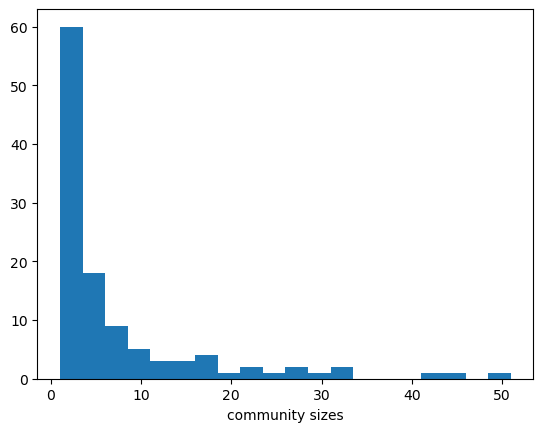

In [123]:
comm_sizes = ['']*len(cset_w10_c10)           # create list with number of items equivalent to number of communities
for idx,community in enumerate(cset_w10_c10): # loop over every community in the graph
    comm_sizes[idx] = len(community)          # get community size
    
plt.hist(comm_sizes,20)
plt.xlabel('community sizes')
plt.show()

### write the communities you've detected to htag_communities_w10_c10.txt

In [124]:
with open('htag_communities_w10_c10.txt' , 'w' , encoding='UTF-8') as fout: # open file to write communities to
    for community in cset_w10_c10:                                          # repeat for every line from input file
        community_str = ','.join(community)                                 # get single string from list of strings
        fout.write('{%s}'%community_str)                                    # write space delimited communities to output file
        fout.write('\n')                                                    # new line between each entry

A community that makes sense from this detection is {babys,kids,children} because all of these are roughly synonyms and it is easy to see why these hashtags would appear together in many tweets.
A community that does not make sense is {urgent,cats,nyc} as there is seemingly no immediatley recognizeable relation between the three hashtags in this set.

### Run community detection for the four quadrants of low/high weight/community thresholds

In [128]:
# graph generation
G_w_low = weight_threshold(G,5)         # low weight threshold
G_w_high = weight_threshold(G,25)       # high weight threshold
G_Q1 = comp_size_threshold(G_w_low,4)   # low c & low w
G_Q2 = comp_size_threshold(G_w_high,4)  # low c & high w
G_Q3 = comp_size_threshold(G_w_low,16)  # high c & low w
G_Q4 = comp_size_threshold(G_w_high,16) # high c & high w

# community detection
cset_Q1 = list(nx_comm.label_propagation_communities(G_Q1))
cset_Q2 = list(nx_comm.label_propagation_communities(G_Q2))
cset_Q3 = list(nx_comm.label_propagation_communities(G_Q3))
cset_Q4 = list(nx_comm.label_propagation_communities(G_Q4))

# write out to text docs
with open('htag_communities_Q1.txt' , 'w' , encoding='UTF-8') as fout: # open file to write communities to
    for community in cset_Q1:                                          # repeat for every line from input file
        community_str = ','.join(community)                            # get single string from list of strings
        fout.write('{%s}'%community_str)                               # write space delimited communities to output file
        fout.write('\n')                                               # new line between each entry
with open('htag_communities_Q2.txt' , 'w' , encoding='UTF-8') as fout:
    for community in cset_Q2: 
        community_str = ','.join(community)
        fout.write('{%s}'%community_str)
        fout.write('\n') 
with open('htag_communities_Q3.txt' , 'w' , encoding='UTF-8') as fout:
    for community in cset_Q3: 
        community_str = ','.join(community) 
        fout.write('{%s}'%community_str) 
        fout.write('\n') 
with open('htag_communities_Q4.txt' , 'w' , encoding='UTF-8') as fout:
    for community in cset_Q4:
        community_str = ','.join(community)
        fout.write('{%s}'%community_str)
        fout.write('\n')

The first quadrant of the graph has the least amount of restrictions on nodes and edges that can remain in the graph, so naturally it has the largest number of communities detected, and many of those communities hold a large number of nodes within them. This can be disadventageous as having many communities of large size means there is a higher chance that there are unrelated nodes within the same communitiy. An example of this is the communitity:

{losangeles,kellyservices,stelle,retail,austin,regional,security,customer,jobs4u,supplychain,software,phoenix,accounting,businessmgmt,houston,montreal,account,roberthalf,engineer,engineering,technician,it,maintenance,hiring,portland,hr,developer,sanantonio,tampa,kellyjobs,physician,manufacturing,clerical,banking,jewellery,hospitality,sales,denver,indianapolis,parttime,seattle,columbus,jobs,cfgjobs,ca,veterans,transportation,healthcare,assistant,500k,intel,coordinator,glendale,job,birmingham,newyork,careerarc,service,dubai,toronto,time,london,income,entry,sanfrancisco,senior,cdl,atlanta,customerservice,charlotte,edmonton,recruitment,manager,sonic,accountemps,the,nursing}


The second quadrant has a high weight threshold and a low component threshold. This means that many more edges are being eliminated. This also effects the component detection because the weight threshold is applied first, meaning that because many edges are removed, there may be components that decrease such that they are below the component size threshold when it is applied. Due to this there are many less communities detected and the communities that are detected have many fewer nodes. While it should be stated that important information can be left out like smaller communities and many large communties can be split up or incomplete, this quadrant can remove some nodes from communities that aren't strongly related. An example of a community in this quadrant that contains nodes that have very similar meanings is:

{blackfriday,kohlssweepstakes,deals,cybermonday}


The third quadrant has a low weight threshold and a high component threshold. As observed before, due to the weight threshold being implimented first, the the high threshold for community size has less of an effect than the high threshold for edge weight. This can be seen in the number of communities detected and the size of those communities, as there are many more communities, and they can be much larger in quadrant three than quadrant two. In comparison to queadrant one, the addition of the high component threshold decreases the number of communities but does not have as siginificant an effect on the size of the communities, specifically the larger communities. An example of this can be seen in the following community that is intact from quadrant one:

{losangeles,kellyservices,stelle,retail,austin,regional,security,customer,jobs4u,supplychain,software,phoenix,accounting,businessmgmt,houston,montreal,account,roberthalf,engineer,engineering,technician,it,maintenance,hiring,portland,hr,developer,sanantonio,tampa,kellyjobs,physician,manufacturing,clerical,banking,jewellery,hospitality,sales,denver,indianapolis,parttime,seattle,columbus,jobs,cfgjobs,ca,veterans,transportation,healthcare,assistant,500k,intel,coordinator,glendale,job,birmingham,newyork,careerarc,service,dubai,toronto,time,london,income,entry,sanfrancisco,senior,cdl,atlanta,customerservice,charlotte,edmonton,recruitment,manager,sonic,accountemps,the,nursing}


The fourth quadrant has the most restrictions on nodes and edges that can remain in the graph, so naturally it has the least number of communities, and of those communities they are much smaller than in the other quadrants. This can be seen as an advantage by ridding the graph of the most outliers and show only the strongest connected nodes from the graph, but this can also be seen as a disadvantage as large amounts of useful information is thrown away. An example of this is the following community, that while the two hashtags are very closely related, it would be expected that there would be many more hashtags that would be very similar and co-occur with them often:

{happythanksgiving,iamthankfulfor}

### Pick a topic/theme that you see in the data and find the communities that correspond bes to that topic

topic: sports

Q1:
{liverpool,sturridge,liderbeşiktaş,0,girondins,bordeaux,lfcfrance,ynwa,molfen,klopp,bor,ajax,lfc,lfcindonesia,uel,mfkvsfbsk,celaja,diadesporting,lfcbou,cerny,fenerbahçe,livbor,beşiktaş,vilvscr}
{panthernation,colorrush,dabonthemfolks,dabonthemturkey,tgiving,carvsdal,interception}
{gopanthers,panthersnation,luuuuke,keepp,keeppounding}
{wedemboyz,gocowboys,dallascowboys,cowboysnation}
{browns,cleveland}
{dalvscar,fieldgoal,panthers,cowboys,nflthanksgiving,touchdown,chivsgb,th4nksgiving}
{card,soccer,cards,football,espn,topps,jersey,nfl}
{nike,retro,sport}
{basketball,nba}
{lions,eagles}
{carolina,dallas}
{europaleague,hommage,celtic,coys}
{bears,packers}
{mobile,playfantasyfootball}
{wjc2015,worldjuniors}
{nflfootball,yahoosports}
{nbfootball,holdnothingback}


Q2:
{colorrush,panthers,cowboys,carvsdal,nfl}
{ynwa,liverpool,lfc,livbor,europaleague,bordeaux}


Q3:
{liverpool,sturridge,liderbeşiktaş,0,girondins,bordeaux,lfcfrance,ynwa,molfen,klopp,bor,ajax,lfc,lfcindonesia,uel,mfkvsfbsk,celaja,diadesporting,lfcbou,cerny,fenerbahçe,livbor,beşiktaş,vilvscr}
{panthernation,colorrush,dabonthemfolks,dabonthemturkey,tgiving,carvsdal,interception}
{gopanthers,panthersnation,luuuuke,keepp,keeppounding}
{wedemboyz,gocowboys,dallascowboys,cowboysnation}
{browns,cleveland}
{dalvscar,fieldgoal,panthers,cowboys,nflthanksgiving,touchdown,chivsgb,th4nksgiving}
{card,soccer,cards,football,espn,topps,jersey,nfl}
{nike,retro,sport}
{basketball,nba}
{lions,eagles}
{carolina,dallas}
{europaleague,hommage,celtic,coys}
{bears,packers}
{mobile,playfantasyfootball}
{wjc2015,worldjuniors}
{nflfootball,yahoosports}
{nbfootball,holdnothingback}


Q4:
{colorrush,panthers,cowboys,carvsdal,nfl}

### Which threshold has communities that best represent the topic

quadrants 1 and three have communities that best represent the topic because there are many more communities that the others have ignored that relate many different topics within sports together without many extraneous nodes

### Is there a threshhold that is clearly the best?

The most promising of the group is quadrant three because it gives lots of information and that other quadrants ignore while still having a threshold to prevent outliers from making a large impact